#Денисов Егор ПМ22-3 Машинное обучение в задачах извлечения знаний из видеоданных
##Цель данной курсовой работы заключается в исследовании и применении методов машинного обучения в контексте извлечения знаний из видеоданных. Конкретно, основное внимание уделено задаче мультикласовой сегментации. В рамках исследования будет обучена модель, способная найти и выделить несколько объектов на видео.

In [3]:
!git clone https://github.com/oldwildman/kursovaya.git

Cloning into 'kursovaya'...
remote: Enumerating objects: 2596, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 2596 (delta 0), reused 1 (delta 0), pack-reused 2593
Receiving objects: 100% (2596/2596), 307.60 MiB | 38.67 MiB/s, done.
Resolving deltas: 100% (14/14), done.
Updating files: 100% (2560/2560), done.


## Импорт библиотек:
## Вывод информации о TensorFlow:

In [4]:
import cv2
import os
import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from skimage import measure
from skimage.io import imread, imsave
from skimage.transform import resize
from skimage.morphology import dilation, disk
from skimage.draw import polygon_perimeter

print(f'Tensorflow version {tf.__version__}')
print(f'GPU is {"ON" if tf.config.list_physical_devices("GPU") else "OFF" }')

Tensorflow version 2.15.0
GPU is ON


##CLASSES:
Определяет количество классов объектов, которые будут распознаваться на видео.


##COLORS:
 Содержит список цветов, используемых для визуализации масок объектов. Каждый класс будет отображаться своим уникальным цветом.


##SAMPLE_SIZE:
 Определяет размер образцов изображений, которые будут использоваться для обучения модели. Изображения будут изменены до этого размера перед подачей в модель.


##OUTPUT_SIZE:
 Определяет целевой размер изображений после изменения. Это размер изображений, которые будут получены после обработки.

In [5]:
CLASSES = 8
COLORS = ['black', 'red', 'lime',
          'blue', 'orange', 'pink',
          'cyan', 'magenta']

SAMPLE_SIZE = (256, 256)
OUTPUT_SIZE = (1080, 1920)

##Функция load_images:
*Принимает пути к файлам изображения и маски.

*Читает и декодирует файл изображения и маски.

*Изменяет размеры изображения и маски до требуемых
размеров.

*Преобразует значения пикселей в диапазон от 0 до 1.

*Создает отдельные маски для каждого класса объектов.

##Функция augmentate_images:
*Принимает изображение и маски объектов.

*Производит случайное обрезание изображения и маски.

*Случайно отражает изображение и маски по горизонтали.

*Изменяет размеры изображения и маски до требуемого размера.

In [6]:
def load_images(image, mask):

    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image)

    image = tf.image.resize(image, OUTPUT_SIZE)

    image = tf.image.convert_image_dtype(image, tf.float32)
    image = image / 255.0


    mask = tf.io.read_file(mask)
    mask = tf.io.decode_png(mask)

    mask = tf.image.rgb_to_grayscale(mask)

    mask = tf.image.resize(mask, OUTPUT_SIZE)

    mask = tf.image.convert_image_dtype(mask, tf.float32)


    masks = []
    for i in range(CLASSES):
        masks.append(tf.where(tf.equal(mask, float(i)), 1.0, 0.0))
    masks = tf.stack(masks, axis=2)
    masks = tf.reshape(masks, OUTPUT_SIZE + (CLASSES,))

    return image, masks



def augmentate_images(image, masks):

    random_crop = tf.random.uniform((), 0.3, 1)
    image = tf.image.central_crop(image, random_crop)
    masks = tf.image.central_crop(masks, random_crop)


    random_flip = tf.random.uniform((), 0, 1)
    if random_flip >= 0.5:
        image = tf.image.flip_left_right(image)
        masks = tf.image.flip_left_right(masks)


    image = tf.image.resize(image, SAMPLE_SIZE)
    masks = tf.image.resize(masks, SAMPLE_SIZE)

    return image, masks


##glob.glob:
чтобы получить список путей к файлам изображений и масок.

##images_dataset и masks_dataset :
создаются из полученных списков путей к файлам изображений и масок соответственно с помощью tf.data.Dataset.from_tensor_slices.

##tf.data.Dataset.zip :
объединяет датасеты изображений и масок поэлементно в один датасет.

##Функция load_images
применяется к датасету пар изображений и масок для загрузки и предобработки изображений и масок.

*Датасет повторяется 60 раз для увеличения данных.

*Функция augmentate_images применяется к датасету     
изображений и масок для аугментации данных. В этой функции происходит случайное обрезание и отражение изображений и масок, а затем их изменение до требуемого размера. Функция применяется с использованием параллельных вызовов для ускорения обработки данных.

In [7]:
images = sorted(glob.glob('kursovaya/dataset/images/*.jpg'))
masks = sorted(glob.glob('kursovaya/dataset/masks/*.png'))

images_dataset = tf.data.Dataset.from_tensor_slices(images)
masks_dataset = tf.data.Dataset.from_tensor_slices(masks)

dataset = tf.data.Dataset.zip((images_dataset, masks_dataset))

dataset = dataset.map(load_images, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.repeat(60)
dataset = dataset.map(augmentate_images, num_parallel_calls=tf.data.AUTOTUNE)

##dataset.take(5)
получает первые 5 элементов из датасета, содержащих изображения и соответствующие им маски.

##list(dataset.take(5))
преобразует эти элементы в список.

##Отображение изображений и масок:

Создается фигура fig и массив подграфиков ax с двумя строками и пятью столбцами.

##В цикле для каждого изображения и маски:

*Изображение отображается на верхнем ряду подграфиков.

*Маска отображается на нижнем ряду подграфиков.

*Для каждого канала маски выделяются контуры объектов, которые отображаются на маске разными цветами в соответствии с цветами классов.

*Визуализация яркости масок уменьшается для лучшего отображения.

##Отображение графика:

###plt.show()
отображает график с изображениями и масками.
###plt.close()
закрывает график после отображения.

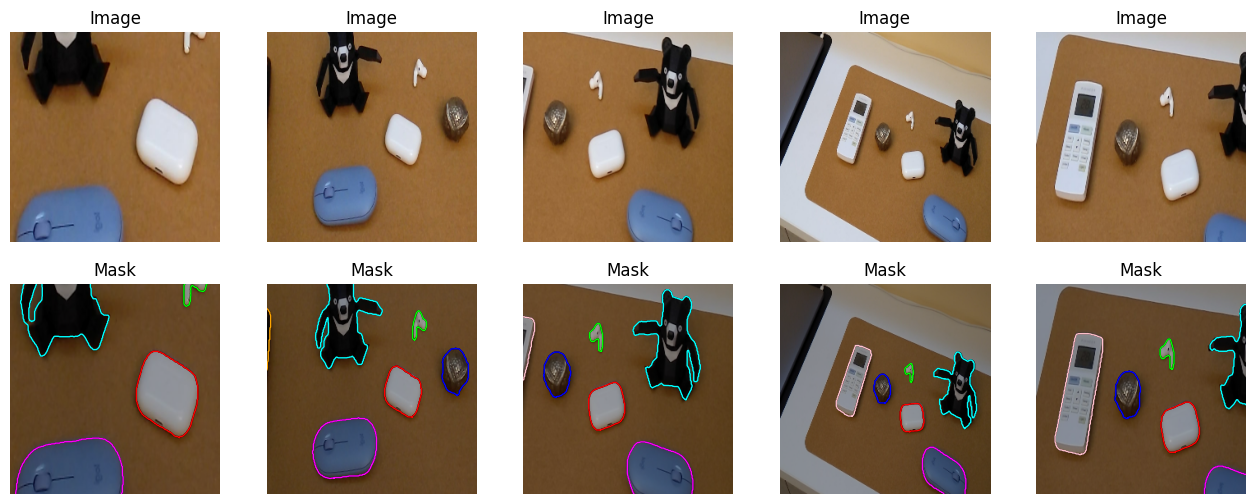

In [8]:
images_and_masks = list(dataset.take(5))

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(16, 6))

for i, (image, masks) in enumerate(images_and_masks):
    ax[0, i].set_title('Image')
    ax[0, i].set_axis_off()
    ax[0, i].imshow(image)

    ax[1, i].set_title('Mask')
    ax[1, i].set_axis_off()
    ax[1, i].imshow(image / 1.5)

    for channel in range(CLASSES):
        contours = measure.find_contours(np.array(masks[:, :, channel]))
        for contour in contours:
            ax[1, i].plot(contour[:, 1], contour[:, 0], linewidth=1, color=COLORS[channel])

plt.show()
plt.close()

#Создание обучающего и тестового датасетов:

##dataset.take(2000)
 берет первые 2000 элементов из общего датасета для обучения.
##dataset.skip(2000).take(100)
 пропускает первые 2000 элементов и берет следующие 100 элементов из общего датасета для тестирования.

##cache()
используется для кэширования элементов в памяти, что ускоряет доступ к ним при обучении.
##train_dataset и test_dataset
содержат соответственно обучающие и тестовые данные.
Разбиение датасетов на пакеты:

##batch(8)
разбивает обучающий и тестовый датасеты на пакеты по 8 элементов каждый. Это помогает эффективному обучению модели, обрабатывая не все данные сразу, а по небольшим порциям (пакетам).

In [9]:
train_dataset = dataset.take(2000).cache()
test_dataset = dataset.skip(2000).take(100).cache()

train_dataset = train_dataset.batch(8)
test_dataset = test_dataset.batch(8)

##input_layer:
Создает входной слой модели с формой (256, 256, 3), где 3 - это количество каналов (RGB).
##downsample_block:
Создает блок сжатия (downsampling block) модели U-Net
##upsample_block:
Создает блок расширения (upsampling block) модели U-Net
##output_layer:
Создает выходной слой модели U-Net

In [ ]:
def input_layer():
    return tf.keras.layers.Input(shape=SAMPLE_SIZE + (3,))

def downsample_block(filters, size, batch_norm=True):
    initializer = tf.keras.initializers.GlorotNormal()

    result = tf.keras.Sequential()

    result.add(
      tf.keras.layers.Conv2D(
          filters,
          size,
          strides=2,
          padding='same',
          kernel_initializer=initializer,
          use_bias=False
          )
      )

    if batch_norm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())
    return result

def upsample_block(filters, size, dropout=False):
    initializer = tf.keras.initializers.GlorotNormal()

    result = tf.keras.Sequential()

    result.add(
        tf.keras.layers.Conv2DTranspose(
            filters,
            size,
            strides=2,
            padding='same',
            kernel_initializer=initializer,
            use_bias=False
            )
        )

    result.add(tf.keras.layers.BatchNormalization())

    if dropout:
        result.add(tf.keras.layers.Dropout(0.25))

    result.add(tf.keras.layers.ReLU())
    return result

def output_layer(size):
    initializer = tf.keras.initializers.GlorotNormal()
    return tf.keras.layers.Conv2DTranspose(
        CLASSES,
        size,
        strides=2,
        padding='same',
        kernel_initializer=initializer,
        activation='sigmoid'
      )

##inp_layer:
Создается входной слой модели.
##downsample_stack и upsample_stack:
Создаются стеки блоков сжатия и расширения соответственно
##Проход по стеку блоков сжатия:
Каждый блок сжатия применяется к входному слою, и результаты сохраняются для дальнейшего использования в skip connections.
##Проход по стеку блоков расширения с использованием skip connections:
Каждый блок расширения применяется к текущему состоянию x, затем результат объединяется с соответствующим блоком сжатия из skip connections.
##Создание модели U-Net:
Модель U-Net создается с входным слоем inp_layer и выходным слоем out_layer.
##Визуализация архитектуры модели:
tf.keras.utils.plot_model используется для визуализации архитектуры модели с помощью графа, показывая форму каждого слоя и соединения между ними.

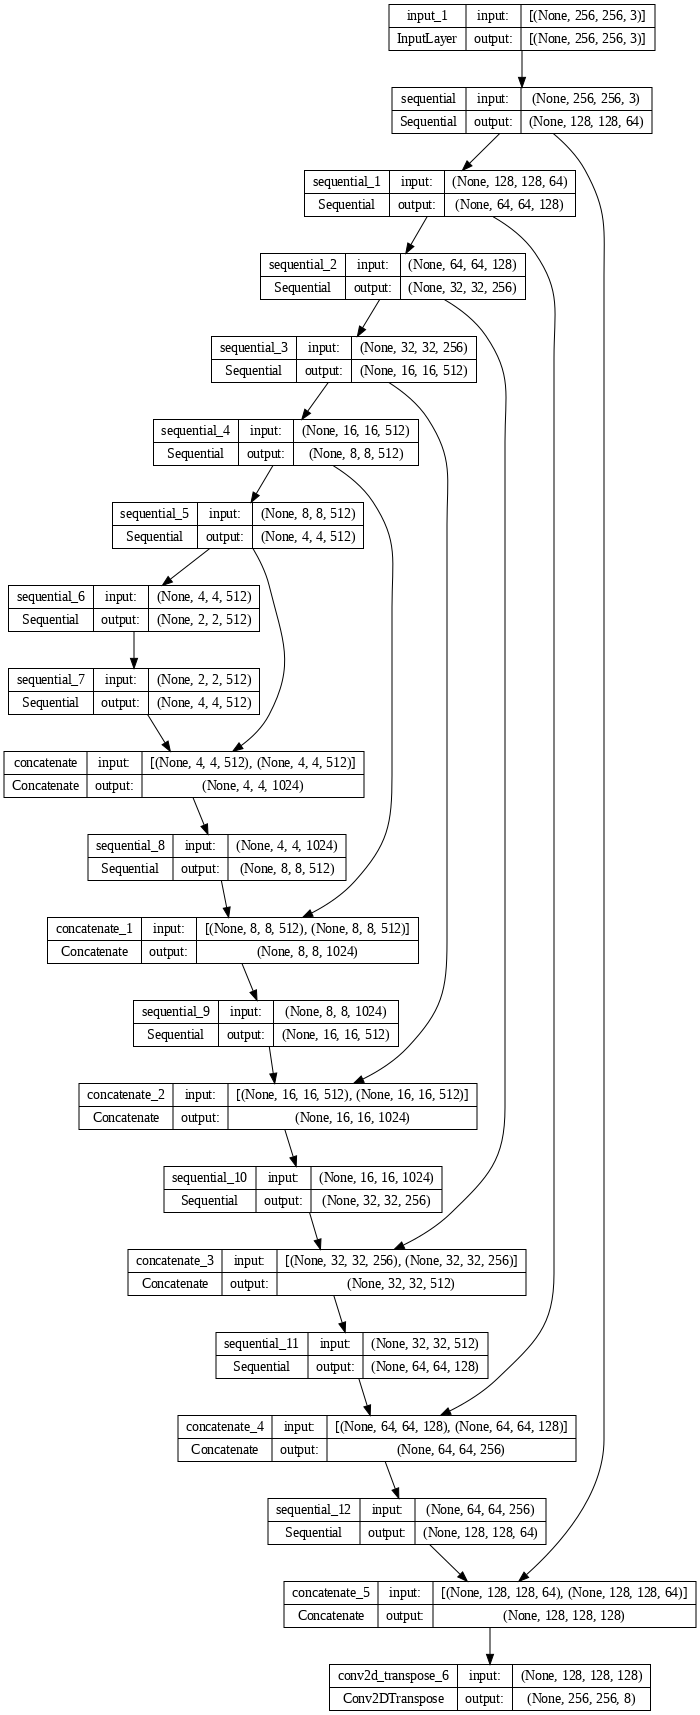

In [ ]:
inp_layer = input_layer()

downsample_stack = [
    downsample_block(64, 4, batch_norm=False),
    downsample_block(128, 4),
    downsample_block(256, 4),
    downsample_block(512, 4),
    downsample_block(512, 4),
    downsample_block(512, 4),
    downsample_block(512, 4),
]

upsample_stack = [
    upsample_block(512, 4, dropout=True),
    upsample_block(512, 4, dropout=True),
    upsample_block(512, 4, dropout=True),
    upsample_block(256, 4),
    upsample_block(128, 4),
    upsample_block(64, 4)
]

out_layer = output_layer(4)

x = inp_layer
downsample_skips = []

for block in downsample_stack:
    x = block(x)
    downsample_skips.append(x)

downsample_skips = reversed(downsample_skips[:-1])

for up_block, down_block in zip(upsample_stack, downsample_skips):
    x = up_block(x)
    x = tf.keras.layers.Concatenate()([x, down_block])

out_layer = out_layer(x)

unet_like = tf.keras.Model(inputs=inp_layer, outputs=out_layer)

tf.keras.utils.plot_model(unet_like, show_shapes=True, dpi=72)

##dice_mc_metric:

*Функция для вычисления метрики Dice для многоклассовой сегментации.

*Принимает предсказанные маски 'a' и истинные маски 'b'.
##'tf.unstack'
используется для распаковки тензоров масок по оси каналов.

*Для каждого класса вычисляется числитель и знаменатель метрики Dice, затем они суммируются для всех классов и усредняются.

*Возвращается усредненное значение метрики Dice для всех классов.
##dice_mc_loss:

Функция для вычисления потерь на основе метрики Dice для многоклассовой сегментации.

##dice_bce_mc_loss:
*Функция для вычисления совмещенных потерь на основе метрики Dice и бинарной кросс-энтропии для многоклассовой сегментации.

*Вычисляется как взвешенная сумма метрики Dice и бинарной кросс-энтропии. В данном случае метрика Dice учитывается с весом 0.3, а бинарная кросс-энтропия - с весом 1.

In [ ]:
def dice_mc_metric(a, b):
    a = tf.unstack(a, axis=3)
    b = tf.unstack(b, axis=3)

    dice_sum = 0

    for i, (aa, bb) in enumerate(zip(a, b)):
        numerator = 2 * tf.math.reduce_sum(aa * bb) + 1
        denominator = tf.math.reduce_sum(aa + bb) + 1
        dice_sum += numerator / denominator

    avg_dice = dice_sum / CLASSES

    return avg_dice

def dice_mc_loss(a, b):
    return 1 - dice_mc_metric(a, b)

def dice_bce_mc_loss(a, b):
    return 0.3 * dice_mc_loss(a, b) + tf.keras.losses.binary_crossentropy(a, b)

##compile используется для компиляции модели перед обучением.

##В качестве оптимизатора используется 'adam'.

##В качестве функции потерь указывается dice_bce_mc_loss, которая включает в себя как метрику Dice, так и бинарную кросс-энтропию.

##Для метрики указывается dice_mc_metric, которая вычисляет усредненное значение метрики Dice для всех классов.

In [ ]:
unet_like.compile(optimizer='adam', loss=dice_bce_mc_loss, metrics=[dice_mc_metric])

##fit
используется для обучения модели.
##train_dataset
используется для обучения, а test_dataset - для валидации.

##Устанавливается количество эпох (25) и начальная эпоха (0).

##После завершения обучения веса модели сохраняются в файл 'unet_like'.

In [ ]:
#сохраняем модели в файл
history_dice = unet_like.fit(train_dataset, validation_data=test_dataset, epochs=25, initial_epoch=0)

unet_like.save_weights('unet_like')

Epoch 1/25
250/250 [==============================] - 3294s 13s/step - loss: 0.2189 - dice_mc_metric: 0.5134 - val_loss: 0.4109 - val_dice_mc_metric: 0.3376
Epoch 2/25
250/250 [==============================] - 2353s 9s/step - loss: 0.0518 - dice_mc_metric: 0.8740 - val_loss: 0.0590 - val_dice_mc_metric: 0.8703
Epoch 3/25
250/250 [==============================] - 2351s 9s/step - loss: 0.0203 - dice_mc_metric: 0.9554 - val_loss: 0.0220 - val_dice_mc_metric: 0.9509
Epoch 4/25
250/250 [==============================] - 2367s 9s/step - loss: 0.0141 - dice_mc_metric: 0.9696 - val_loss: 0.0381 - val_dice_mc_metric: 0.9149
Epoch 5/25
250/250 [==============================] - 2348s 9s/step - loss: 0.0119 - dice_mc_metric: 0.9747 - val_loss: 0.0448 - val_dice_mc_metric: 0.9151
Epoch 6/25
250/250 [==============================] - 2296s 9s/step - loss: 0.0228 - dice_mc_metric: 0.9534 - val_loss: 0.0403 - val_dice_mc_metric: 0.9291
Epoch 7/25
250/250 [==============================] - 2273s 9s/

##load_weights
 используется для загрузки весов модели из файла

##'unet_like'.

In [ ]:
unet_like.load_weights('unet_like')

##rgb_colors
содержит цвета для каждого класса объектов.

*Цикл 'for' перебирает каждый кадр видео.

*Каждый кадр изменяется до размера 'SAMPLE_SIZE' и передается в модель unet_like для предсказания.

*Предсказание преобразуется в изображение с помощью метода reshape.

*Масштабирование 'scale' используется для восстановления координат контуров к оригинальному размеру кадра.

*Исходный кадр уменьшается на 1.5 и преобразуется в тип 'uint8.'

*Для каждого класса, начиная с индекса 1 (т.е. кроме фона), находятся контуры объектов и добавляются на кадр с соответствующим цветом из 'rgb_colors'.

*Полученный кадр сохраняется в папку 'kursovaya/videos/processed/' с тем же именем файла.

In [ ]:
rgb_colors = [
    (0,   0,   0),
    (255, 0,   0),
    (0,   255, 0),
    (0,   0,   255),
    (255, 165, 0),
    (255, 192, 203),
    (0,   255, 255),
    (255, 0,   255)
]

frames = sorted(glob.glob('kursovaya/videos/original_video/*.jpg'))

for filename in frames:
    frame = imread(filename)
    sample = resize(frame, SAMPLE_SIZE)

    predict = unet_like.predict(sample.reshape((1,) +  SAMPLE_SIZE + (3,)))
    predict = predict.reshape(SAMPLE_SIZE + (CLASSES,))

    scale = frame.shape[0] / SAMPLE_SIZE[0], frame.shape[1] / SAMPLE_SIZE[1]

    frame = (frame / 1.5).astype(np.uint8)

    for channel in range(1, CLASSES):
        contour_overlay = np.zeros((frame.shape[0], frame.shape[1]))
        contours = measure.find_contours(np.array(predict[:,:,channel]))

        try:
            for contour in contours:
                rr, cc = polygon_perimeter(contour[:, 0] * scale[0],
                                           contour[:, 1] * scale[1],
                                           shape=contour_overlay.shape)

                contour_overlay[rr, cc] = 1

            contour_overlay = dilation(contour_overlay, disk(1))
            frame[contour_overlay == 1] = rgb_colors[channel]
        except:
            pass

    imsave(f'kursovaya/videos/processed/{os.path.basename(filename)}', frame)

*В цикле 'for' проходится по всем изображениям в папке 'kursovaya/videos/processed/'.

*Каждое изображение считывается с помощью 'cv2.imread', а затем записывается в видео с помощью 'video.write'.

*После записи всех изображений в видеофайл освобождаются ресурсы с помощью 'cv2.destroyAllWindows()' и 'video.release()'.

In [ ]:
import cv2
import os

image_folder = f'kursovaya/videos/processed/'
video_name = 'video1.mp4'

images = [img for img in os.listdir(image_folder) if img.endswith(".jpg")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 30.0, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!zip -r /content/kursovaya/videos/processed.zip /content/kursovaya/videos/processed
from google.colab import files
files.download("/content/kursovaya/videos/processed.zip")

In [ ]:
!zip /content/video.zip /content/video.avi
from google.colab import files
files.download("/content/video.zip")


#Библиография
##1."U-Net: Convolutional Networks for Biomedical Image Segmentation"
Оригинальная статья о модели U-Net, которая широко используется в задачах сегментации изображений.
https://arxiv.org/abs/1505.04597

##2."A Survey of Semantic Segmentation"

Обзор различных методов семантической сегментации изображений.

https://arxiv.org/abs/2001.05566

##3."Semantic Segmentation: A Comprehensive Survey"

Еще один обзор методов семантической сегментации с подробным рассмотрением различных подходов.

https://arxiv.org/abs/1905.02188

##4."Dice Loss for Data-imbalanced NLP Tasks"

Статья о потерях Dice, которые применяются в задачах сегментации.

https://arxiv.org/abs/1911.02855

##5."Binary Cross-Entropy Loss"

Описание бинарной кросс-энтропии, которая часто используется в задачах классификации и сегментации.

https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#binary-cross-entropy

##6."Introduction to OpenCV"

Руководство по библиотеке OpenCV, которая используется для обработки изображений и создания видео.

https://opencv.org/


##7."NumPy User Guide"

Руководство пользователя по библиотеке NumPy, которая широко используется для работы с массивами и матрицами в Python.

https://numpy.org/doc/stable/user/index.html








In [11]:
import os
import requests
from nbconvert import PDFExporter
from nbconvert import HTMLExporter
from nbformat import read

def convert_notebook_to_pdf(notebook_path):
    # Читаем .ipynb файл
    with open(notebook_path, 'r', encoding='utf-8') as f:
        nb = read(f, as_version=4)

    # Инициализируем экспортер в PDF
    pdf_exporter = PDFExporter()

    # Конвертируем ноутбук в HTML
    html_exporter = HTMLExporter()
    (body, resources) = html_exporter.from_notebook_node(nb)

    # Определяем временное местоположение HTML
    temp_html_file = "temp.html"
    with open(temp_html_file, 'w', encoding='utf-8') as f:
        f.write(body)

    # Конвертируем HTML в PDF
    os.system(f"wkhtmltopdf {temp_html_file} temp.pdf")

    # Удаляем временные файлы
    os.remove(temp_html_file)

    return "temp.pdf"

def download_file(url, file_name):
    with open(file_name, "wb") as f:
        response = requests.get(url)
        f.write(response.content)

if __name__ == "__main__":
    notebook_path = "kurdenisov.ipynb"  # Путь к вашему ноутбуку
    pdf_file = convert_notebook_to_pdf(notebook_path)

    # Скачиваем PDF файл
    download_file(pdf_file, "kursach.pdf")


FileNotFoundError: [Errno 2] No such file or directory: 'kurdenisov.ipynb'